### 지도학습 > 분류 > 분류 결과에 대한 평가

In [1]:
from matplotlib import pyplot as plt
import sklearn.datasets
import pandas as pd

In [2]:
# 아이리스 데이터 로드
def attach_iris_df() :
    # 데이터 로드
    ds = sklearn.datasets.load_iris()
    # print(type(ds), ds['data'])
    # DataFrame 구성
    df = pd.DataFrame(ds['data'], columns = ds['feature_names'])
    # print(df.head())
    # print(ds)
    # 레이블 데이터 컬럼명은 species로 df에 추가 
    '''
    tmp = []
    for target in ds['target'] :
        for idx, name in enumerate(ds['target_names']) :
            if target == idx :
                tmp.append(name)
    df['species'] = tmp
    '''
    # { 0 : 'setosa', ... }
    tmp = dict(zip(range(3), ds['target_names']))
    df['species'] = [tmp[idx] for idx in ds['target']]
    
    return df

In [3]:
df = attach_iris_df()

In [4]:
# roc, auc를 이용한 성능평가 수행
# 모듈 가져오기
import sklearn
# 측정 패키지
from sklearn.metrics import roc_curve, auc
# 훈련용, 테스트용 분류
from sklearn.model_selection import train_test_split
# 분류 알고리즘
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [6]:
# 분류 알고리즘별로 손쉽게 시각화를 하기 위해 값 세팅
class_map = {
    '로지스틱 회귀' : ('-', LogisticRegression()),
    '결정 트리' : ('--', DecisionTreeClassifier(max_depth = 5)),
    '랜덤 포레스트' : ('.-', RandomForestClassifier(max_depth = 5, n_estimators = 10, max_features = 1)),
    '나이브 베이즈' : (':', GaussianNB())
}

In [10]:
df.head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa


In [9]:
df.shape

(150, 5)

In [12]:
# 데이터를 나눠서 임시 구성
# species를 제외하고 나머지만 150*4
X = df[df.columns[:4]]
X.head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


In [13]:
X.shape

(150, 4)

In [14]:
# Y는 이진 분류 데이터로 구성하겠다
# 종이 versicolor인지 아닌지로 구성, 튜플
Y = df['species'] == 'versicolor'
Y[:2], type(Y), Y.shape

(0    False
 1    False
 Name: species, dtype: bool, pandas.core.series.Series, (150,))

In [15]:
# 데이터를 훈련용, 테스트용
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.8)

In [16]:
X_train.shape, X_test.shape

((30, 4), (120, 4))

In [18]:
for a in class_map.items() :
    print(a)

('로지스틱 회귀', ('-', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)))
('결정 트리', ('--', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')))
('랜덤 포레스트', ('.-', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
      

In [19]:
from korea_font import initKoreaFontLoad
initKoreaFontLoad()

Malgun Gothic


로지스틱 회귀 auc : 0.7303809833930316
결정 트리 auc : 0.851188537935526
랜덤 포레스트 auc : 0.9843699120807554
나이브 베이즈 auc : 0.9726473461413221


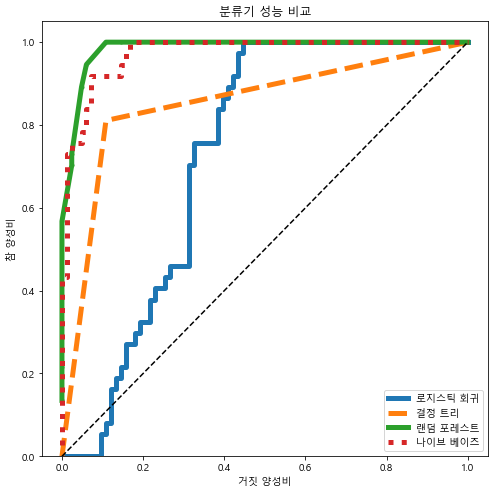

In [59]:
plt.figure(figsize=(8, 8))
for name, (line_style, model) in class_map.items() :
    # 훈련
    model.fit(X_train, Y_train)
    # 예측
    # predict_proba() : 예측에 대한 확률로 예측
    # → 알고리즘의 신뢰 수준을 알 수가 없다는 점에서 활용
    # ('0, 1 중에 1이 될 확률 0.57이다'
    # → 1을 상대적으로 더 예측하는 모델인데, 
    # 만약 해당 모델이 0을 더 잘 맞춘다고 본다면 예측값은 0으로 해석)
    # predict() : 예측값을 기준으로 예측
    preds = model.predict_proba( X_test )
    # print(preds[:,1])
    
    # roc 커브 생성
    pred = pd.Series(preds[:, 1])
    # print(pred)
    # fpr : 거짓 양성비
    # tpr : 참 양성비
    # thresholds : fpr, tpr을 계산할 때 사용한 결정함수의 임계값
    fpr, tpr, thresholds = roc_curve( Y_test, pred )
    # print(fpr, tpr, thresholds)
    
    # auc 스코어 → 수치 비교
    auc_score = auc(fpr, tpr)
    print('%s auc : %s' % (name, auc_score))
    # 그리기
    plt.plot( fpr, tpr, line_style, linewidth=5, label=name )
    
plt.legend()
plt.title('분류기 성능 비교')
# 구분을 위해 대각선 기울기가 1인 선을 드로잉
plt.plot( [0,1], [0,1], 'k--' )
# 구간 제한
plt.ylim( [0.0, 1.05] )

# 라벨
plt.xlabel('거짓 양성비')
plt.ylabel('참 양성비')
plt.show()

In [60]:
# 매크로 평균, 마이크로 평균
from sklearn.metrics import f1_score
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]

In [61]:
# 매크로 평균 기반
# 정밀도 = 참의 개별값 합산 / (참의 개별값 합산 + 거짓의 개별값 합산)
f1_score(y_true, y_pred, average = 'macro')

0.26666666666666666

In [63]:
# 마이크로 평균 기반
# 정밀도 = (정밀도1 + 정밀도2 + ...) / n개의 클래스 분류 개수
f1_score(y_true, y_pred, average = 'micro')

0.3333333333333333

In [64]:
f1_score(y_true, y_pred, average = 'weighted')

0.26666666666666666

In [65]:
f1_score(y_true, y_pred, average = None)

array([0.8, 0. , 0. ])

### 지도학습 > 회귀 > 회귀 모델에 대한 평가
- 지표(추천시스템에서 체크)
 > - 평균 제곱근 오차  
 > - 결정계수

### 기타 > A/B 테스트
- 일반 SW에서 테스트 하는 방식 혼용